In [2]:
import os

import cv2
import numpy as np
from matplotlib import pyplot as plt
import skimage as ski

In [3]:
def image_show(image):
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(111)

    ax.imshow(image[:, :, ::-1])
    ax.axis("off")

    fig.tight_layout()
    plt.show()


def gray_show(gray, color="gray"):
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(111)

    ax.imshow(gray, color)
    ax.axis("off")

    fig.tight_layout()
    plt.show()


def grid_show(images, colors):
    fig = plt.figure(figsize=(8, 5))

    for i, (X, c) in enumerate([*zip(images, colors)], 1):  # type: ignore
        ax = fig.add_subplot(len(images) // 2, 2, i)
        ax.imshow(X, c)
        ax.axis("off")

    fig.tight_layout()
    plt.show()

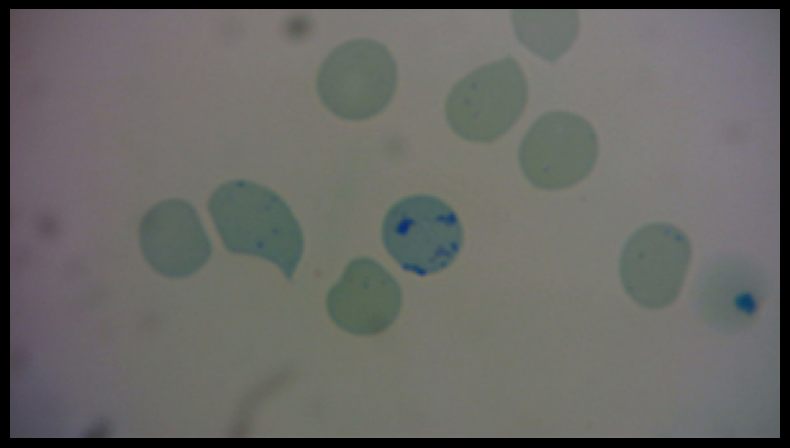

In [4]:
# image = cv2.imread("teste_1/reticulocitos.png")[45:445, 200:600]
image = cv2.imread("data/images/001734.jpg")[66:233, :, :]

image_show(image)

In [5]:
print(image.shape)

(167, 300, 3)


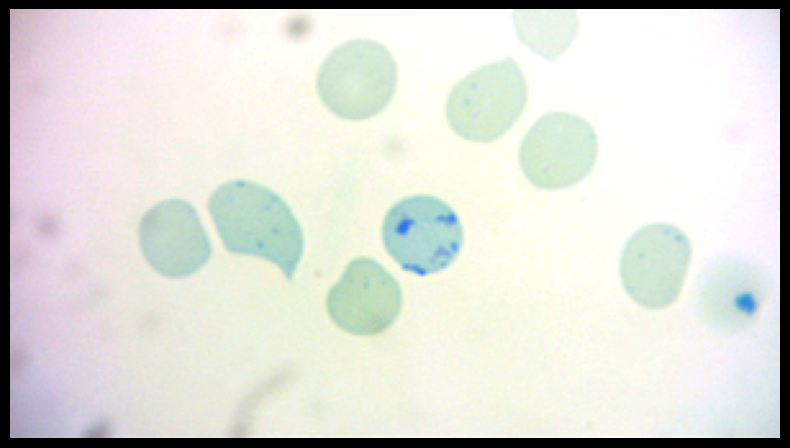

In [84]:
alpha = 1.95 # Contrast control (1.0-3.0)
beta = 20 # Brightness control (0-100)

image_ = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

image_show(image_)


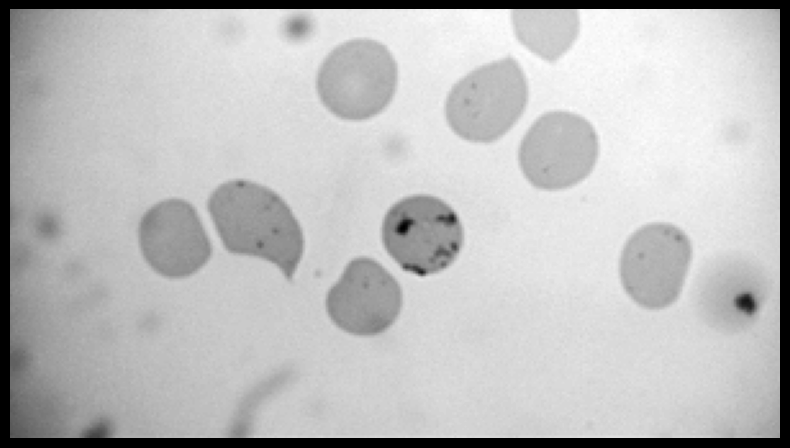

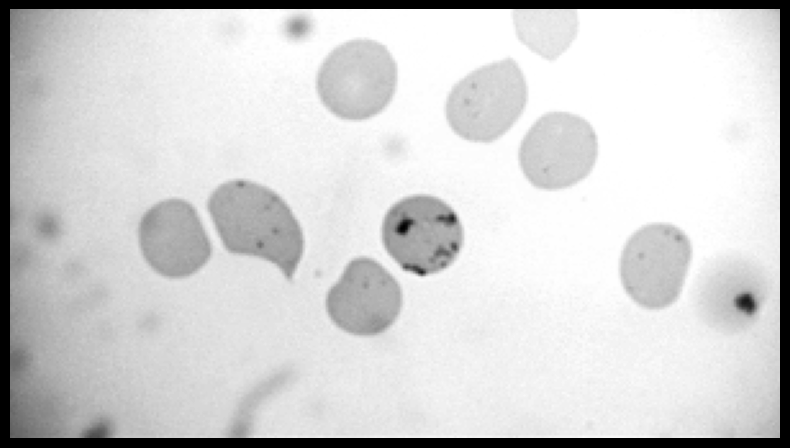

In [85]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray_ = cv2.cvtColor(image_, cv2.COLOR_BGR2GRAY)

gray_show(gray)
gray_show(gray_)

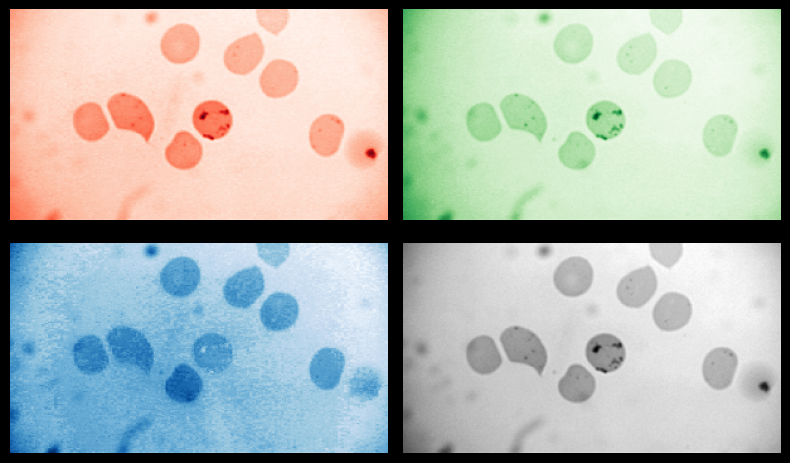

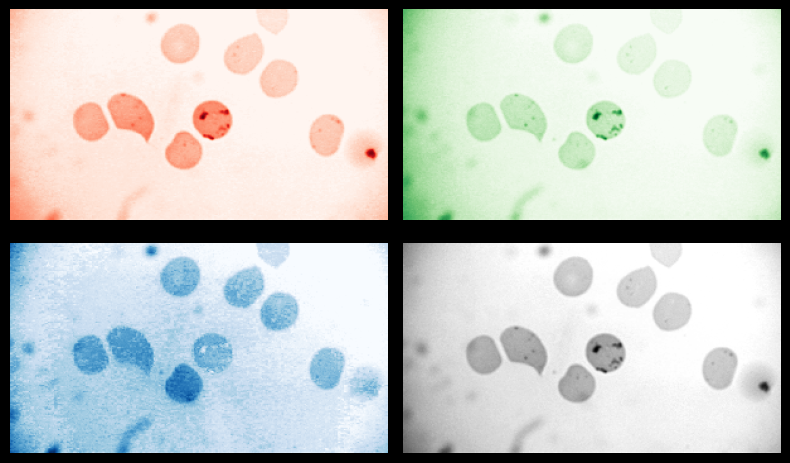

In [86]:
red = image[:, :, 2]
green = image[:, :, 1]
blue = image[:, :, 0]

grid_show([255 - red, 255 - green, 255 - blue, gray], ["Reds", "Greens", "Blues", "gray"])  # type: ignore

red_ = image_[:, :, 2]
green_ = image_[:, :, 1]
blue_ = image_[:, :, 0]

grid_show([255 - red_, 255 - green_, 255 - blue_, gray_], ["Reds", "Greens", "Blues", "gray"])  # type: ignore

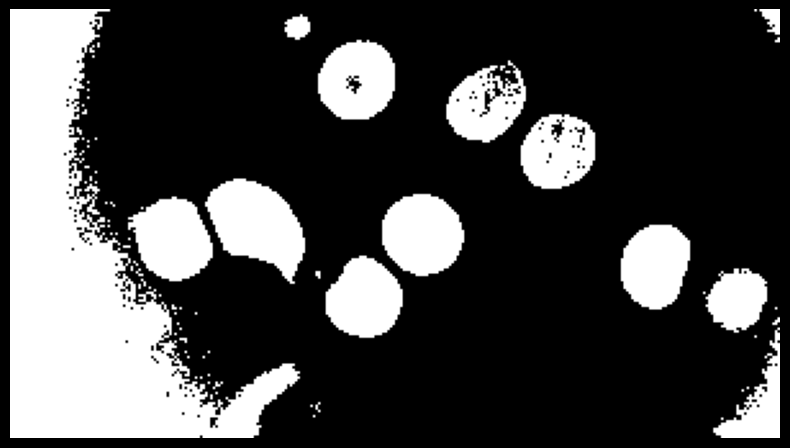

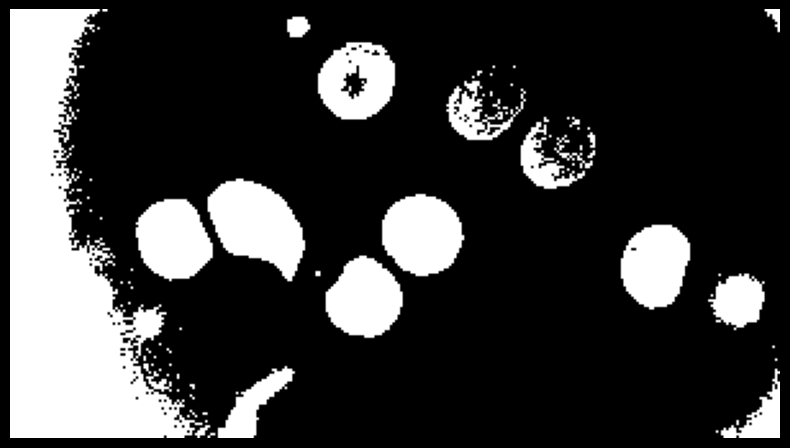

In [87]:
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
thresh_ = cv2.threshold(gray_, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

gray_show(255 - thresh)  # type: ignore
gray_show(255 - thresh_)  # type: ignore

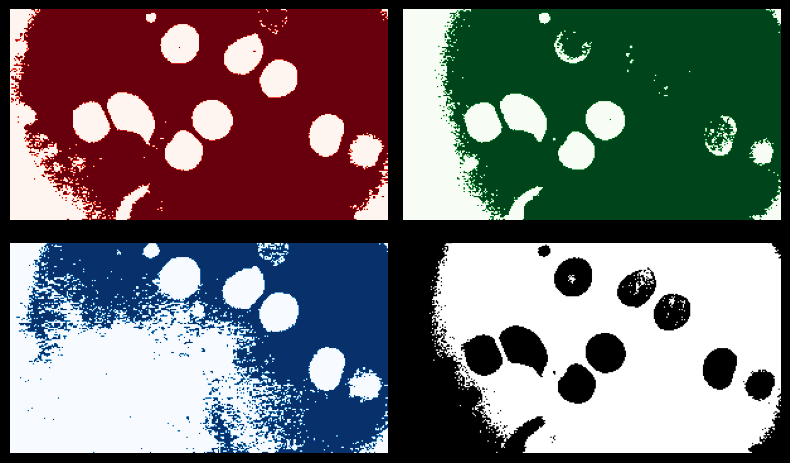

In [88]:
grid_show(list(map(lambda X: cv2.threshold(X, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1], [red, green, blue, gray])), ["Reds", "Greens", "Blues", "gray"])  # type: ignore

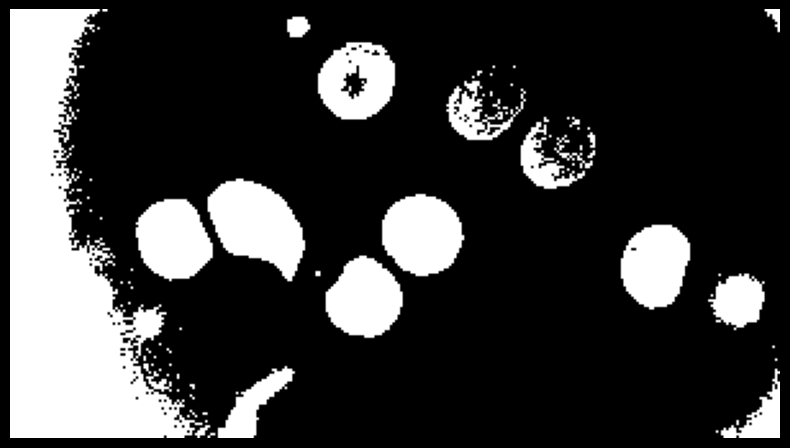

In [102]:
kernel = np.ones((3, 3), np.uint8)

binary = 255 - thresh_  # type: ignore

gray_show(binary)

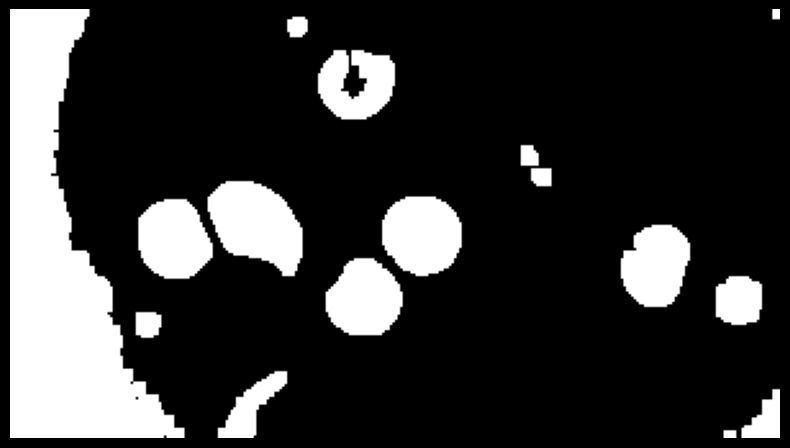

In [103]:
# noise removal
opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)

gray_show(opening)

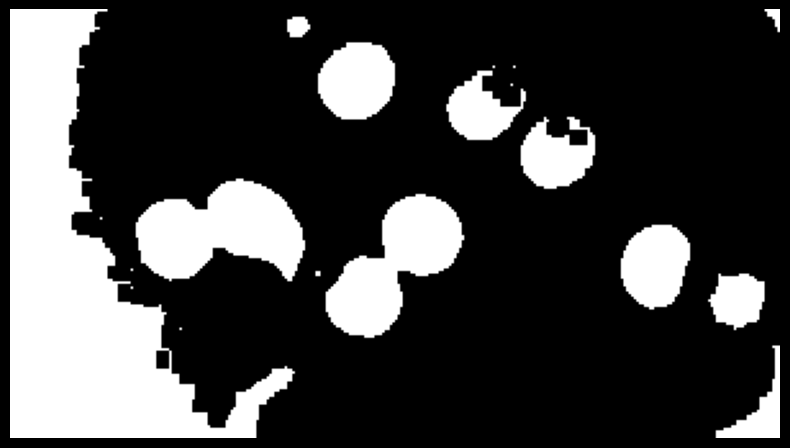

In [104]:
closing = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=2)

gray_show(closing)

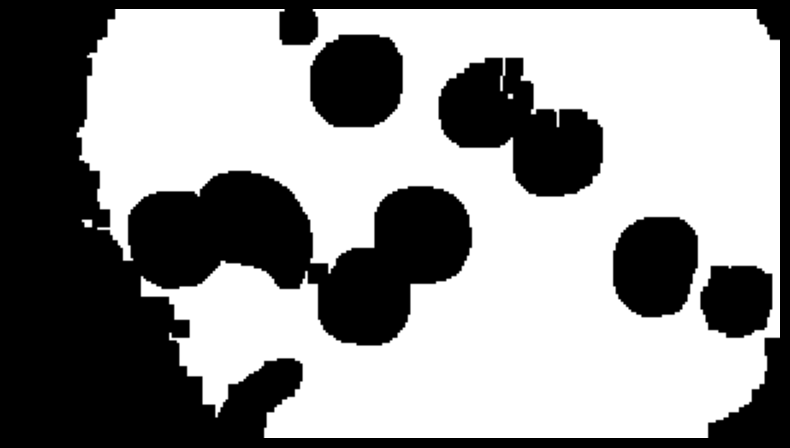

In [105]:
# sure background area
sure_bg = 255 - cv2.dilate(closing, kernel, iterations=3) # type: ignore

gray_show(sure_bg)

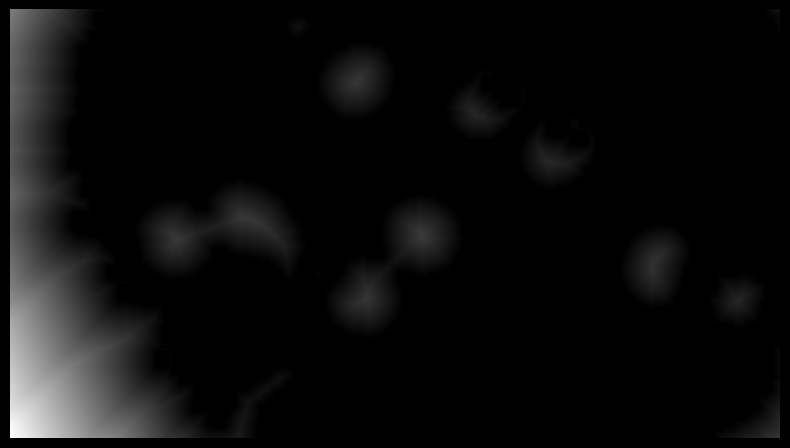

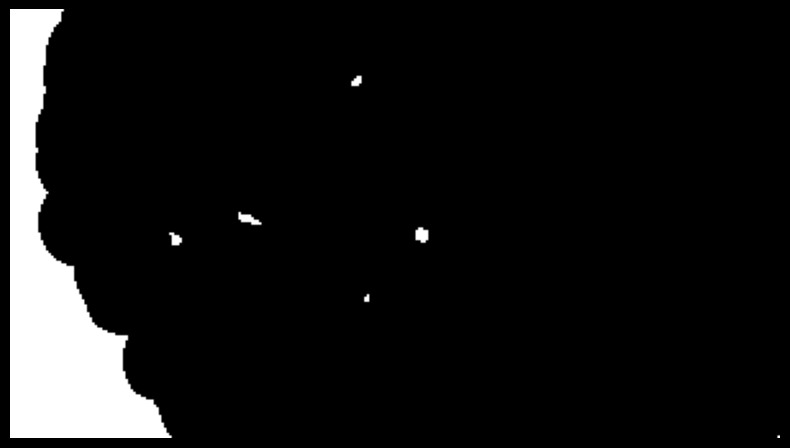

In [111]:
# Finding sure foreground area
dist_transform = cv2.distanceTransform(closing, cv2.DIST_L2, 3)
gray_show(dist_transform)

sure_fg = cv2.threshold(dist_transform, 0.2 * dist_transform.max(), 255, 0)[1]
sure_fg = np.array(sure_fg, dtype=np.uint8)

gray_show(sure_fg)

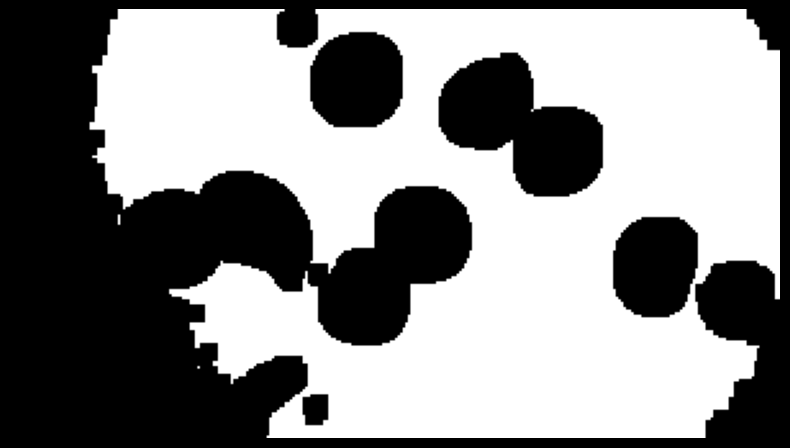

In [94]:
# Finding unknown region
unknown = cv2.subtract(sure_bg, sure_fg)

gray_show(unknown)

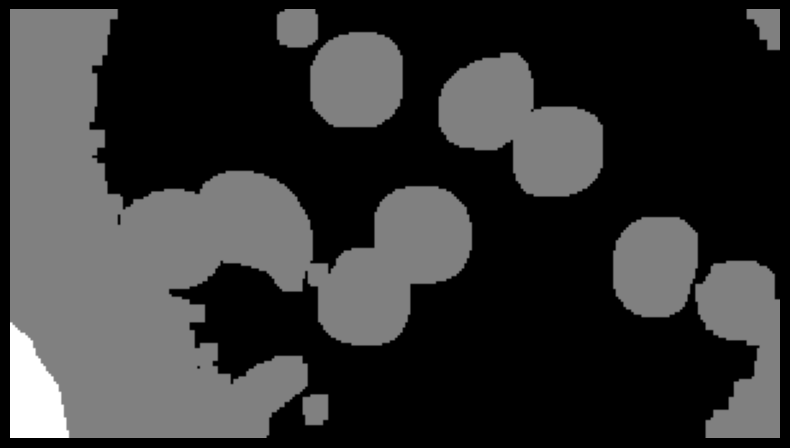

In [95]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = np.add(markers, 1)

# Now, mark the region of unknown with zero
markers[unknown == 255] = 0

gray_show(markers)

In [96]:
temp = image.copy()

markers = cv2.watershed(temp, markers)
temp[markers == -1] = [255, 0, 0]

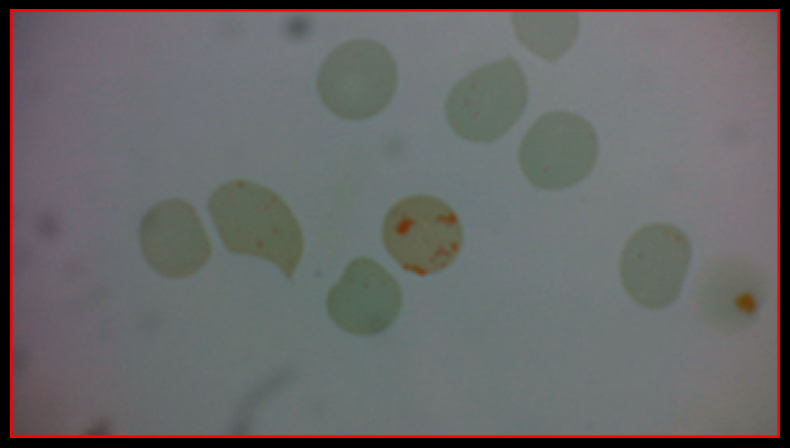

In [97]:
image_show(temp[:, :, ::-1])

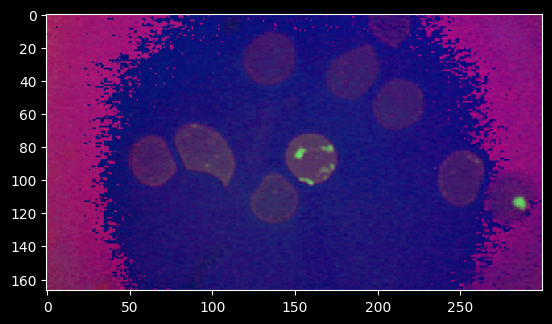

In [98]:
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

plt.imshow(hsv)

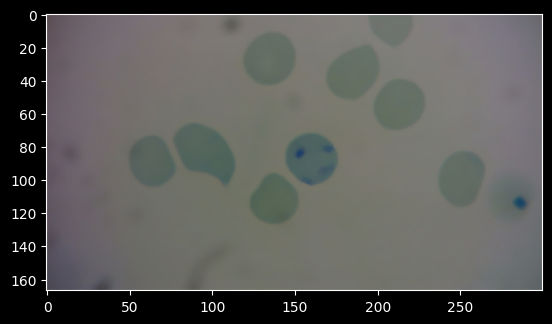

In [99]:
blur = cv2.medianBlur(image, 5)

plt.imshow(blur[:, :, ::-1])

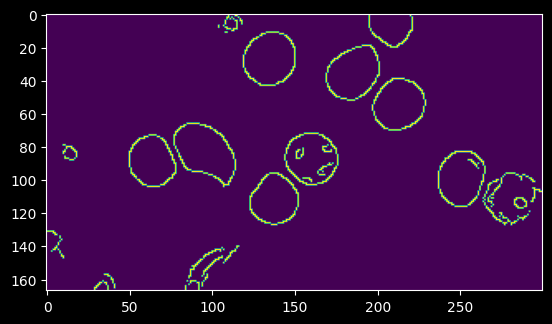

In [100]:
canny = cv2.Canny(blur, 10, 30)

plt.imshow(canny)

In [101]:
contours, _ = cv2.findContours(canny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

draw = image.copy()
for i, cnt in enumerate(contours):
    peri = cv2.arcLength(i, True)
    approx = cv2.approxPolyDP(i, 0.03 * peri, True)
    cv2.drawContours(draw, cnt, [0], (0, 0, 0), 1)

plt.imshow(draw[:, :, ::-1])

error: OpenCV(4.9.0) /io/opencv/modules/imgproc/src/shapedescr.cpp:280: error: (-215:Assertion failed) count >= 0 && (depth == CV_32F || depth == CV_32S) in function 'arcLength'


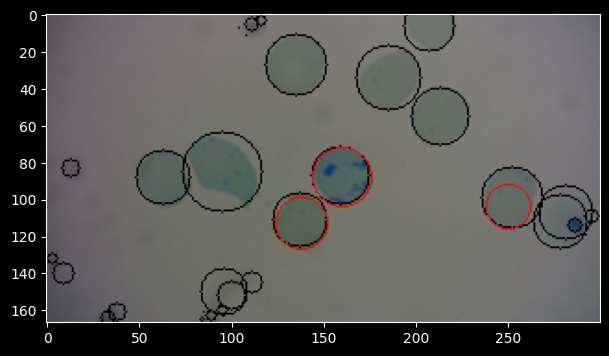

In [ ]:
edges = ski.feature.canny(gray)

hough_radii = np.arange(10, 35, 2)
hough_res = ski.transform.hough_circle(edges, hough_radii)

accums, cx, cy, radii = ski.transform.hough_circle_peaks(
    hough_res, hough_radii, 10, 10, 0.4
)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))

draw = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
for center_y, center_x, radius in zip(cy, cx, radii):
    circy, circx = ski.draw.circle_perimeter(
        center_y, center_x, radius, shape=image.shape
    )
    draw[circy, circx] = (220, 20, 20)

ax.imshow(draw, cmap="gray")
plt.show()